# Import Library

In [1]:
# %matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load data

In [2]:
data=pd.read_csv('data\mass_31012025.csv',comment='#', delim_whitespace=True)
data

,X_Value,Channel4,Channel3,Channel2,Channel1
0,0.000000e+00,-0.0072,-0.0008,-0.0040,0.0020
1,2.000000e-10,-0.0080,-0.0008,-0.0036,0.0020
2,4.000000e-10,-0.0088,-0.0008,-0.0032,0.0020
3,6.000000e-10,-0.0084,-0.0016,-0.0036,0.0020
4,8.000000e-10,-0.0076,-0.0012,-0.0036,0.0020
...,...,...,...,...,...
2540630,2.640247e+05,-0.0076,-0.0012,-0.0052,0.0024
2540631,2.640247e+05,-0.0080,-0.0012,-0.0044,0.0024
2540632,2.640247e+05,-0.0076,-0.0016,-0.0028,0.0040
2540633,2.640247e+05,-0.0080,-0.0012,-0.0028,0.0044


In [3]:
cols = data.columns[1:].tolist()
cols.reverse()
cols= [data.columns[0]] + cols
cols

['X_Value', 'Channel1', 'Channel2', 'Channel3', 'Channel4']

In [4]:
data=data[cols]
data

,X_Value,Channel1,Channel2,Channel3,Channel4
0,0.000000e+00,0.0020,-0.0040,-0.0008,-0.0072
1,2.000000e-10,0.0020,-0.0036,-0.0008,-0.0080
2,4.000000e-10,0.0020,-0.0032,-0.0008,-0.0088
3,6.000000e-10,0.0020,-0.0036,-0.0016,-0.0084
4,8.000000e-10,0.0020,-0.0036,-0.0012,-0.0076
...,...,...,...,...,...
2540630,2.640247e+05,0.0024,-0.0052,-0.0012,-0.0076
2540631,2.640247e+05,0.0024,-0.0044,-0.0012,-0.0080
2540632,2.640247e+05,0.0040,-0.0028,-0.0016,-0.0076
2540633,2.640247e+05,0.0044,-0.0028,-0.0012,-0.0080


# Plot Events

Adding a column for `event_ID` and repeated the `X_Value` of the first event for all events

In [5]:
# Define event size
event_size = 4001

# Ensure the DataFrame can be evenly split
num_events = len(data) // event_size
print(f'Expected number of events: {num_events}')

# Assign an Event_ID column to the DataFrame
data = data.iloc[:num_events * event_size].copy()  # Trim excess rows if any
data.insert(0,'Event_ID', data.index // event_size)


# Replace 'X_Value' for all events with 'times' from event 0
times = data[data['Event_ID'] == 0]['X_Value'].values
data['X_Value'] = np.tile(times, num_events)

#Store each event in the events list
events = []
for event_id in range(num_events):
    event_data = data[data['Event_ID'] == event_id]
    events.append(event_data)
# Optionally, store each event in separate CSV files    
    # event_data.to_csv(f"event_{event_id + 1}.csv", index=False)

# Print confirmation
print(f"Total events extracted: {len(events)}")

data

Expected number of events: 635
Total events extracted: 635


,Event_ID,X_Value,Channel1,Channel2,Channel3,Channel4
0,0,0.000000e+00,0.0020,-0.0040,-0.0008,-0.0072
1,0,2.000000e-10,0.0020,-0.0036,-0.0008,-0.0080
2,0,4.000000e-10,0.0020,-0.0032,-0.0008,-0.0088
3,0,6.000000e-10,0.0020,-0.0036,-0.0016,-0.0084
4,0,8.000000e-10,0.0020,-0.0036,-0.0012,-0.0076
...,...,...,...,...,...,...
2540630,634,7.992000e-07,0.0024,-0.0052,-0.0012,-0.0076
2540631,634,7.994000e-07,0.0024,-0.0044,-0.0012,-0.0080
2540632,634,7.996000e-07,0.0040,-0.0028,-0.0016,-0.0076
2540633,634,7.998000e-07,0.0044,-0.0028,-0.0012,-0.0080


In [6]:
def plot_event(num_event):
    by_event=data.groupby(data.Event_ID)
    event=(by_event.get_group(num_event)).drop(columns=['Event_ID'])
    event.plot(x='X_Value', y=['Channel4','Channel3','Channel2','Channel1'],
           xlim=(4e-7,7e-7), legend='True', #kind='scatter',
           title='Event '+str(num_event))
    
def print_line(line,df):
    mask = df['Event_ID'] == line
    print(df[mask])

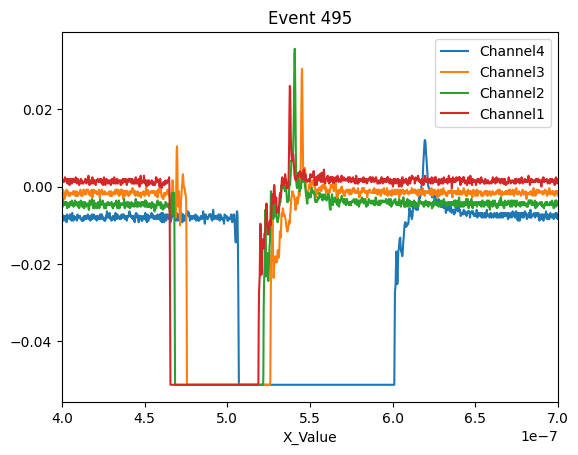

In [7]:
plot_event(495)

In [8]:
data.columns[2:]

Index(['Channel1', 'Channel2', 'Channel3', 'Channel4'], dtype='object')

# Determination of the velocity 

In [9]:
#Experiemntal constant 
D12=64e-2 #m
D23=88e-2 #m
D13= 152e-2 #m
d= 2.85e-2 #m: thickness of lead

#Fundamental constant
c=3e8

In [10]:
def find_detection_times(data):
    '''less efficient version'''
    nevent = len(data) // event_size
    by_event = data.groupby(data.Event_ID)
    detection_times={}
    for event in range(nevent):
        data_event = by_event.get_group(event) #.drop(columns=['Event_ID'])
        dtimes = {}
        for channel in data_event.columns[1:-1]:
            k=0
            while np.abs(data_event[channel].iloc[k]) < 0.02:
                k+=1
            dtimes[channel] = data_event['X_Value'].iloc[k]
        detection_times[event]=dtimes
        dfres = pd.DataFrame(detection_times).transpose()
    return dfres

alternative version

In [11]:
def compute_detection_times(data, threshold=0.04):
    # Assume the DataFrame has columns: 'Event_ID', channel columns, and 'X_Value' as the last column.
    channels = data.columns[2:]  # Excludes 'Event_ID' and 'X_Value'
    
    # Reshape data to a long format: one row per measurement per channel.
    melted = data.melt(id_vars=['Event_ID', 'X_Value'],
                       value_vars=channels,
                       var_name='channel',
                       value_name='signal')
    
    # Filter rows where the absolute signal exceeds the threshold.
    filtered = melted[np.abs(melted['signal']) > threshold]
   #  print(filtered)
    
    # For each Event_ID and channel, find the smallest X_Value where the condition is met.
    detection_times = filtered.groupby(['Event_ID','channel'])['X_Value'].min().unstack()
    
 # Reset index so that 'Event_ID' becomes a column instead of the index.
    detection_times = detection_times.reset_index()
    
    # Remove the column index name ('channel') when printing the DataFrame.
    detection_times.columns.name = None

    return detection_times


In [12]:
detection_times = compute_detection_times(data)
detection_times

,Event_ID,Channel1,Channel2,Channel3,Channel4
0,0,4.670000e-07,4.692000e-07,4.724000e-07,5.080000e-07
1,1,4.694000e-07,4.694000e-07,4.736000e-07,5.080000e-07
2,2,4.676000e-07,4.690000e-07,4.738000e-07,5.078000e-07
3,3,4.682000e-07,4.690000e-07,4.734000e-07,5.078000e-07
4,4,4.670000e-07,4.686000e-07,4.736000e-07,5.074000e-07
...,...,...,...,...,...
630,630,4.674000e-07,4.684000e-07,4.708000e-07,5.072000e-07
631,631,4.686000e-07,4.686000e-07,4.742000e-07,5.070000e-07
632,632,4.672000e-07,4.684000e-07,4.720000e-07,5.070000e-07
633,633,4.646000e-07,4.684000e-07,4.730000e-07,5.070000e-07


In [13]:
detection_times['Dt21'] = detection_times.Channel2 - detection_times.Channel1
detection_times['Dt32'] = detection_times.Channel3 - detection_times.Channel2
detection_times['Dt31'] = detection_times.Channel3 - detection_times.Channel1
detection_times

,Event_ID,Channel1,Channel2,Channel3,Channel4,Dt21,Dt32,Dt31
0,0,4.670000e-07,4.692000e-07,4.724000e-07,5.080000e-07,2.200000e-09,3.200000e-09,5.400000e-09
1,1,4.694000e-07,4.694000e-07,4.736000e-07,5.080000e-07,0.000000e+00,4.200000e-09,4.200000e-09
2,2,4.676000e-07,4.690000e-07,4.738000e-07,5.078000e-07,1.400000e-09,4.800000e-09,6.200000e-09
3,3,4.682000e-07,4.690000e-07,4.734000e-07,5.078000e-07,8.000000e-10,4.400000e-09,5.200000e-09
4,4,4.670000e-07,4.686000e-07,4.736000e-07,5.074000e-07,1.600000e-09,5.000000e-09,6.600000e-09
...,...,...,...,...,...,...,...,...
630,630,4.674000e-07,4.684000e-07,4.708000e-07,5.072000e-07,1.000000e-09,2.400000e-09,3.400000e-09
631,631,4.686000e-07,4.686000e-07,4.742000e-07,5.070000e-07,0.000000e+00,5.600000e-09,5.600000e-09
632,632,4.672000e-07,4.684000e-07,4.720000e-07,5.070000e-07,1.200000e-09,3.600000e-09,4.800000e-09
633,633,4.646000e-07,4.684000e-07,4.730000e-07,5.070000e-07,3.800000e-09,4.600000e-09,8.400000e-09


In [14]:
def event_exclusion(detection_times):
    nevent = len(data) // event_size
    mask = (detection_times['Dt21'] > 0) & (detection_times['Dt32'] > 0) & (detection_times['Dt31'] > 0) #& (detection_times['Dt21'] < detection_times['Dt32'] ) 
    excluded_events = detection_times[~mask]
    kept_event = detection_times[mask].drop(columns=['Event_ID'])
    ndropped = nevent - np.sum(mask)
    print('Number of dropped event:', ndropped)
    return kept_event.reset_index(names='Event_ID'), excluded_events


In [15]:
kept_detection_times, excluded_detect_times = event_exclusion(detection_times)
kept_detection_times

Number of dropped event: 160


,Event_ID,Channel1,Channel2,Channel3,Channel4,Dt21,Dt32,Dt31
0,0,4.670000e-07,4.692000e-07,4.724000e-07,5.080000e-07,2.200000e-09,3.200000e-09,5.400000e-09
1,2,4.676000e-07,4.690000e-07,4.738000e-07,5.078000e-07,1.400000e-09,4.800000e-09,6.200000e-09
2,3,4.682000e-07,4.690000e-07,4.734000e-07,5.078000e-07,8.000000e-10,4.400000e-09,5.200000e-09
3,4,4.670000e-07,4.686000e-07,4.736000e-07,5.074000e-07,1.600000e-09,5.000000e-09,6.600000e-09
4,5,4.654000e-07,4.690000e-07,4.732000e-07,5.076000e-07,3.600000e-09,4.200000e-09,7.800000e-09
...,...,...,...,...,...,...,...,...
470,629,4.656000e-07,4.684000e-07,4.720000e-07,5.070000e-07,2.800000e-09,3.600000e-09,6.400000e-09
471,630,4.674000e-07,4.684000e-07,4.708000e-07,5.072000e-07,1.000000e-09,2.400000e-09,3.400000e-09
472,632,4.672000e-07,4.684000e-07,4.720000e-07,5.070000e-07,1.200000e-09,3.600000e-09,4.800000e-09
473,633,4.646000e-07,4.684000e-07,4.730000e-07,5.070000e-07,3.800000e-09,4.600000e-09,8.400000e-09


In [16]:
def randplot_excluded(df,num):
    assert num <= max(df.index), "num should be less or equal to the maximal index of df !"
    nfalse =np.random.randint(0,len(df), size=num)
    for n in list(nfalse):
        id = df.iloc[n,0]
        plot_event(id)

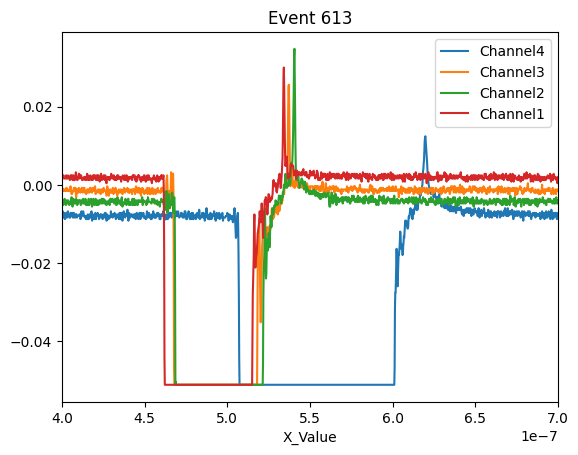

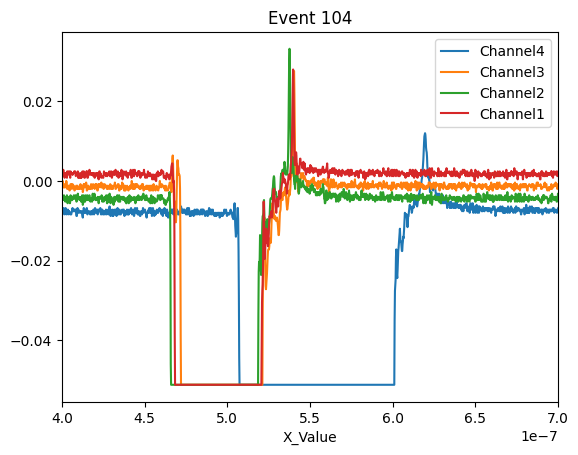

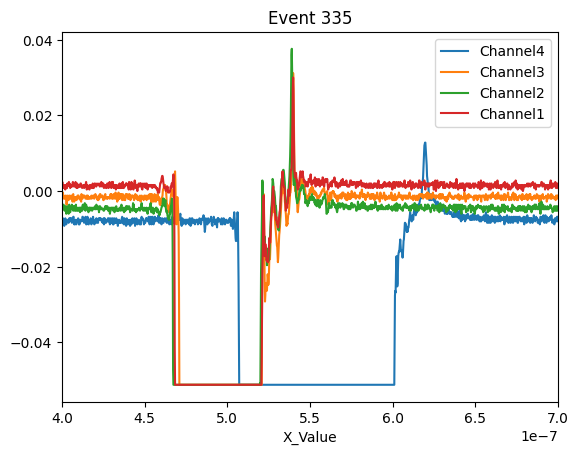

In [17]:
randplot_excluded(excluded_detect_times, 3)

In [18]:
def compute_velocities(Dt):
    velocities = pd.DataFrame(columns=['Event_ID','v12','v23','v13'])

    velocities['Event_ID']= Dt['Event_ID']
    velocities['v12']= D12/Dt['Dt21']
    velocities['v23']= D23/Dt['Dt32']
    velocities['v13']=D13/Dt['Dt31']
    
    mask = (velocities.v12/c > 1) | (velocities.v23/c > 1) | (velocities.v13/c > 1)
    false_velocities = velocities[mask]
    true_velocities = velocities[~mask]
    
    print('Number of supraluminic events:', len(false_velocities))
    
    return  false_velocities, true_velocities

false_vel, true_vel = compute_velocities(kept_detection_times)
    

Number of supraluminic events: 404


In [20]:
true_vel

,Event_ID,v12,v23,v13
0,0,2.909091e+08,2.750000e+08,2.814815e+08
4,5,1.777778e+08,2.095238e+08,1.948718e+08
8,10,2.000000e+08,1.913043e+08,1.948718e+08
16,23,2.461538e+08,2.000000e+08,2.171429e+08
33,50,2.666667e+08,1.833333e+08,2.111111e+08
...,...,...,...,...
451,602,2.000000e+08,2.588235e+08,2.303030e+08
457,610,2.133333e+08,2.933333e+08,2.533333e+08
467,626,2.461538e+08,1.571429e+08,1.853659e+08
470,629,2.285714e+08,2.444444e+08,2.375000e+08


In [19]:
false_vel

,Event_ID,v12,v23,v13
1,2,4.571429e+08,1.833333e+08,2.451613e+08
2,3,8.000000e+08,2.000000e+08,2.923077e+08
3,4,4.000000e+08,1.760000e+08,2.303030e+08
5,6,1.454545e+08,6.285714e+08,2.620690e+08
6,8,1.066667e+09,2.933333e+08,4.222222e+08
...,...,...,...,...
468,627,1.280000e+08,6.285714e+08,2.375000e+08
469,628,4.571429e+08,2.095238e+08,2.714286e+08
471,630,6.400000e+08,3.666667e+08,4.470588e+08
472,632,5.333333e+08,2.444444e+08,3.166667e+08


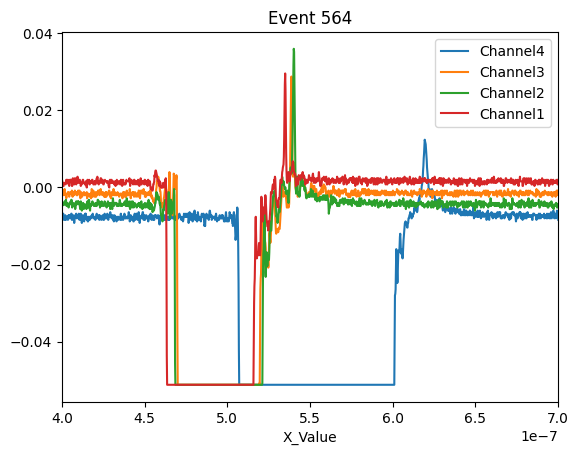

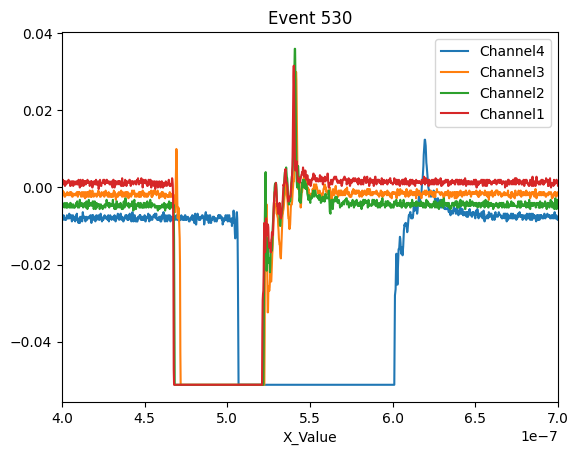

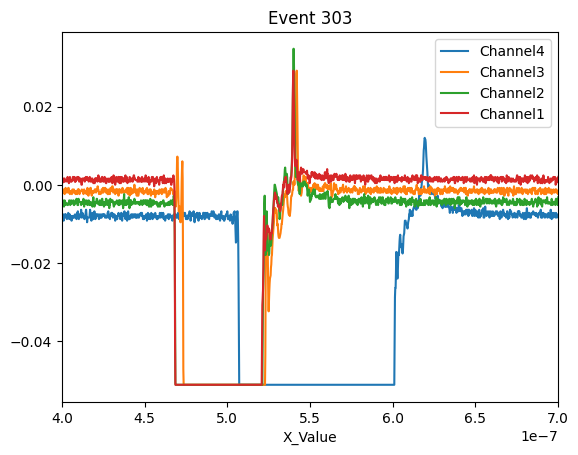

In [21]:
randplot_excluded(false_vel,3)


In [22]:
print_line(288, false_vel)

     Event_ID           v12           v23           v13
209       288  1.230769e+08  3.142857e+08  1.900000e+08


# Determination of the mass